In [37]:
import sys
import os

# Defina manualmente o caminho para o diretório do módulo
module_path = '/Users/catarinabarros/Documents/GitHub/non_linear_beam/code/module'
sys.path.append(module_path)

from nonlinearprocess import get_frequency_data, get_time_data, lowpass_filter, get_parameters, set_file_name, plot_fft, bandpass_filter, get_frf,perform_optimization

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
import scipy.io
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
import torch.nn.functional as F

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

g = 9.81

In [38]:
folder_path = "/Users/catarinabarros/Documents/GitHub/non_linear_beam/Experimental Data"


frf_mec_dir_004g = "/Users/catarinabarros/Documents/GitHub/non_linear_beam/Experimental Data/Frequency response/mec-frf/0.04g/0.04g.txt"
frf_mec_dir_006g = "/Users/catarinabarros/Documents/GitHub/non_linear_beam/Experimental Data/Frequency response/mec-frf/0.06g/0.06g.txt"
frf_mec_dir_008g = "/Users/catarinabarros/Documents/GitHub/non_linear_beam/Experimental Data/Frequency response/mec-frf/0.08g/0.08g.txt"
frf_mec_dir_010g = "/Users/catarinabarros/Documents/GitHub/non_linear_beam/Experimental Data/Frequency response/mec-frf/0.10g/0.10g.txt"
frf_mec_dir_012g = "/Users/catarinabarros/Documents/GitHub/non_linear_beam/Experimental Data/Frequency response/mec-frf/0.12g/0.12g.txt"
frf_mec_dir_014g = "/Users/catarinabarros/Documents/GitHub/non_linear_beam/Experimental Data/Frequency response/mec-frf/0.14g/0.14g.txt"

In [39]:
freq_004g_mec, amplitude_004g_mec_sweepup = get_frequency_data(frf_mec_dir_004g)
_, amplitude_004g_mec_sweepdown = get_frequency_data(frf_mec_dir_004g, sweep_up= False)

freq_006g_mec, amplitude_006g_mec_sweepup = get_frequency_data(frf_mec_dir_006g)
_, amplitude_006g_mec_sweepdown = get_frequency_data(frf_mec_dir_006g, sweep_up= False)

freq_008g_mec, amplitude_008g_mec_sweepup = get_frequency_data(frf_mec_dir_008g)
_, amplitude_008g_mec_sweepdown = get_frequency_data(frf_mec_dir_008g, sweep_up= False)

freq_010g_mec, amplitude_010g_mec_sweepup = get_frequency_data(frf_mec_dir_010g)
_, amplitude_010g_mec_sweepdown = get_frequency_data(frf_mec_dir_010g, sweep_up= False)

freq_012g_mec, amplitude_012g_mec_sweepup = get_frequency_data(frf_mec_dir_012g)
_, amplitude_012g_mec_sweepdown = get_frequency_data(frf_mec_dir_012g, sweep_up= False)

freq_014g_mec, amplitude_014g_mec_sweepup = get_frequency_data(frf_mec_dir_014g)
_, amplitude_014g_mec_sweepdown = get_frequency_data(frf_mec_dir_014g, sweep_up= False)


In [40]:
def duffing_model(freq, acc):
    """
    Fit Duffing model for given frequency and acceleration.

    Parameters:
    -----------
    - freq: array-like
        Array of frequencies.
    - acc: float
        Acceleration as a percentage of g.

    Returns:
    -----------
    - Tuple containing (freq, a_): numpy arrays
        - freq: Array of frequencies where the real positive roots are found.
        - a_: Array of corresponding real positive roots.
    """
    beta = 6.2e+11
    w = 8.78e+02
    A = 1.9 * acc * 9.81
    gamma = 1.96
    return get_frf(freq, beta, w, A, gamma)


In [41]:

def set_error(amp_duffing, amp_exp):
    # Resize amp_exp to match the length of amp_duffing
    return amp_duffing - amp_exp

In [42]:

# Supondo que você já tenha definido ou obtido freq_004g_mec, freq_006g_mec, etc.
# e amplitude_004g_mec_sweepup, amplitude_006g_mec_sweepup, etc.

# Lista de tuplas de frequências e amplitudes
datasets = [
    (freq_004g_mec, 0.04, amplitude_004g_mec_sweepup),
    (freq_006g_mec, 0.06, amplitude_006g_mec_sweepup),
    (freq_008g_mec, 0.08, amplitude_008g_mec_sweepup),
    (freq_010g_mec, 0.10, amplitude_010g_mec_sweepup),
    (freq_012g_mec, 0.12, amplitude_012g_mec_sweepup),
    (freq_014g_mec, 0.14, amplitude_014g_mec_sweepup)
]

# Dicionários para armazenar as frequências e amplitudes máximas por amplitude de excitação
frequencies_data = {}
amplitudes_data = {}

# Processamento para cada dataset
for freq_data, acc, amp_data in datasets:
    # Calcular as amplitudes usando o modelo de Duffing
    freqs, amps = duffing_model(freq_data, acc)
    
    # Encontrar as frequências únicas e suas amplitudes máximas
    unique_freqs, indices = np.unique(freqs, return_index=True)
    max_amps = amps[indices]
    
    # Armazenar apenas a maior amplitude para cada frequência única
    final_freqs = []
    final_amps = []
    for freq, amp in zip(unique_freqs, max_amps):
        if freq not in final_freqs:
            final_freqs.append(freq)
            final_amps.append(amp)
        else:
            index = final_freqs.index(freq)
            if amp > final_amps[index]:
                final_amps[index] = amp

    # Armazenar os resultados finais por amplitude de excitação
    frequencies_data[acc] = np.array(final_freqs)
    amplitudes_data[acc] = np.array(final_amps)

# Atribuição dos dados a variáveis individuais
f004 = frequencies_data[0.04]
a004 = amplitudes_data[0.04]

f006 = frequencies_data[0.06]
a006 = amplitudes_data[0.06]

f008 = frequencies_data[0.08]
a008 = amplitudes_data[0.08]

f010 = frequencies_data[0.10]
a010 = amplitudes_data[0.10]

f012 = frequencies_data[0.12]
a012 = amplitudes_data[0.12]

f014 = frequencies_data[0.14]
a014 = amplitudes_data[0.14]



In [43]:
error_004 = set_error(a004, amplitude_004g_mec_sweepup)
error_006 = set_error(a006, amplitude_006g_mec_sweepup)
error_008 = set_error(a008, amplitude_008g_mec_sweepup)
error_010 = set_error(a010, amplitude_010g_mec_sweepup)
error_012 = set_error(a012, amplitude_012g_mec_sweepup)
error_014 = set_error(a014, amplitude_014g_mec_sweepup)

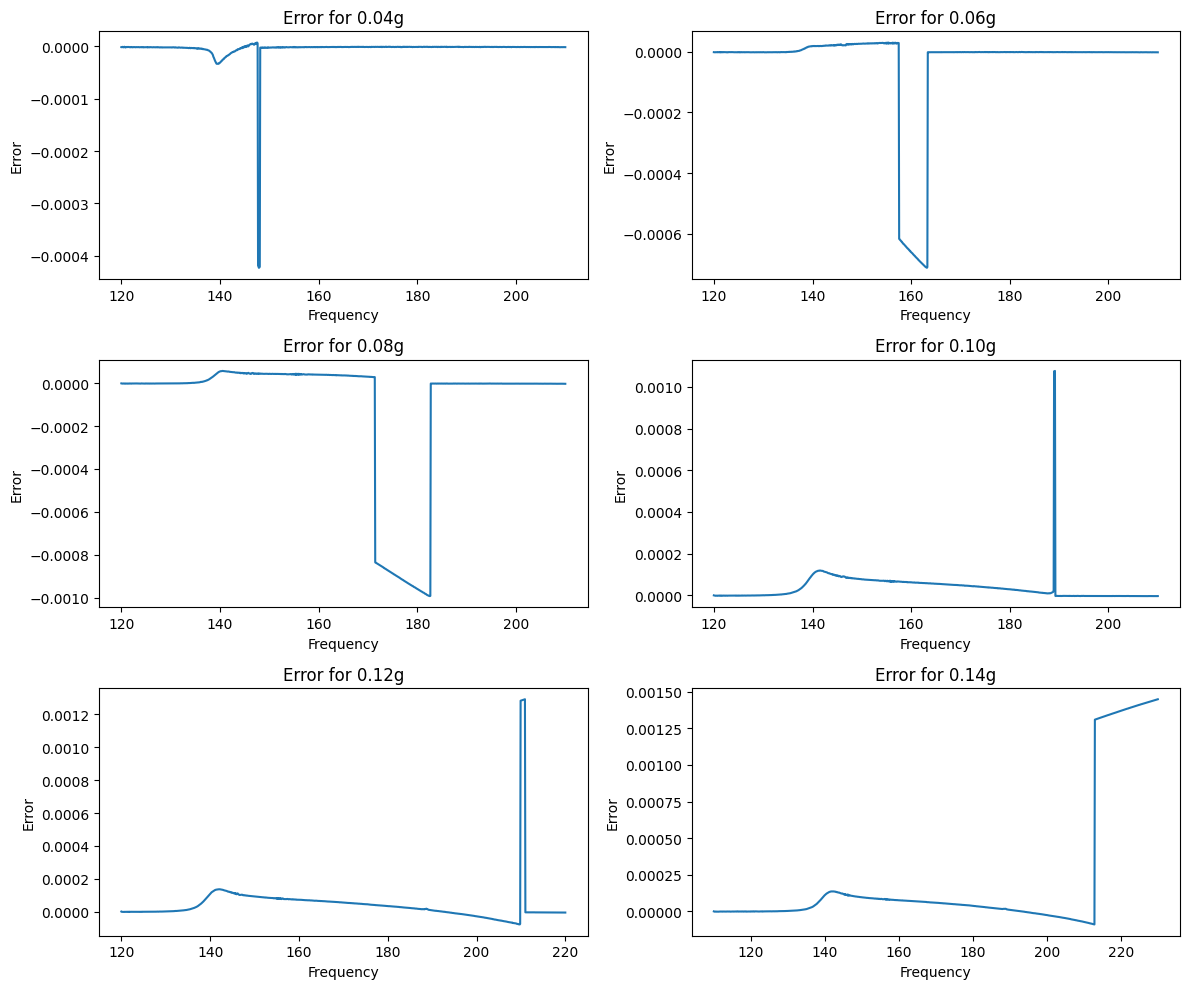

In [44]:


# Assuming errors and frequencies are already calculated and stored in variables error_004, f004, etc.

# Create subplots for each acceleration level
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

# Plot for 0.04g
axs[0, 0].plot(f004, error_004, label='Error')
axs[0, 0].set_title('Error for 0.04g')
axs[0, 0].set_xlabel('Frequency')
axs[0, 0].set_ylabel('Error')

# Plot for 0.06g
axs[0, 1].plot(f006, error_006, label='Error')
axs[0, 1].set_title('Error for 0.06g')
axs[0, 1].set_xlabel('Frequency')
axs[0, 1].set_ylabel('Error')

# Plot for 0.08g
axs[1, 0].plot(f008, error_008, label='Error')
axs[1, 0].set_title('Error for 0.08g')
axs[1, 0].set_xlabel('Frequency')
axs[1, 0].set_ylabel('Error')

# Plot for 0.10g
axs[1, 1].plot(f010, error_010, label='Error')
axs[1, 1].set_title('Error for 0.10g')
axs[1, 1].set_xlabel('Frequency')
axs[1, 1].set_ylabel('Error')

# Plot for 0.12g
axs[2, 0].plot(f012, error_012, label='Error')
axs[2, 0].set_title('Error for 0.12g')
axs[2, 0].set_xlabel('Frequency')
axs[2, 0].set_ylabel('Error')

# Plot for 0.14g
axs[2, 1].plot(f014, error_014, label='Error')
axs[2, 1].set_title('Error for 0.14g')
axs[2, 1].set_xlabel('Frequency')
axs[2, 1].set_ylabel('Error')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [45]:
import numpy as np

# Listas para armazenar os dados de treino e teste
X_treino = []
y_treino = []

X_teste = []
y_teste = []

# Amplitudes de excitação que queremos incluir no treino e teste
amplitudes_treino = [0.04, 0.08, 0.12]
amplitudes_teste = [0.06, 0.10, 0.14]

# Função para calcular o erro entre amplitudes de Duffing e amplitudes experimentais
def set_error(amp_duffing, amp_exp):
    return amp_duffing - amp_exp

# Iteração pelos dados de frequências e amplitudes
for acc in amplitudes_treino:
    freqs = frequencies_data[acc]
    amps = amplitudes_data[acc]
    error = set_error(amps, globals()[f'amplitude_{int(acc*100):03d}g_mec_sweepup'])
    X_treino.append(np.vstack((freqs, np.full_like(freqs, acc))).T)  # Adicionando a aceleração 0.04g como segunda coluna de X_treino
    y_treino.append(error)

for acc in amplitudes_teste:
    freqs = frequencies_data[acc]
    amps = amplitudes_data[acc]
    error = set_error(amps, globals()[f'amplitude_{int(acc*100):03d}g_mec_sweepup'])
    X_teste.append(np.vstack((freqs, np.full_like(freqs, acc))).T)  # Adicionando a aceleração correspondente como segunda coluna de X_teste
    y_teste.append(error)

# Converter listas em arrays NumPy para manipulação mais fácil
X_treino = np.concatenate(X_treino)
y_treino = np.concatenate(y_treino)

X_teste = np.concatenate(X_teste)
y_teste = np.concatenate(y_teste)



In [46]:
X_treino.shape, X_teste.shape, y_treino.shape, y_teste.shape

((3072, 2), (3072, 2), (3072,), (3072,))

In [47]:
X_train = torch.from_numpy(X_treino.astype(np.float32))
X_test = torch.from_numpy(X_teste.astype(np.float32))
y_train = torch.from_numpy(y_treino.astype(np.float32)).view(-1, 1)  # Ensure y has shape [N, 1]
y_test = torch.from_numpy(y_teste.astype(np.float32)).view(-1, 1)    # Ensure y has shape [N, 1]



In [48]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 10)
        self.fc2 = nn.Linear(10,5)
        self.saida = nn.Linear(5, output_size)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.saida(x)
        return x


In [49]:
model = NeuralNet(2, 1)

In [50]:
learning_rate = 0.01
loss_array = []
num_epochs = int(1e4)
batch_size = 1
steps_per_epoch = (len(X_train) + batch_size - 1) // batch_size
total_steps = steps_per_epoch * num_epochs * batch_size

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(optimizer, max_lr=learning_rate, epochs=num_epochs, steps_per_epoch=steps_per_epoch, pct_start=0.5, anneal_strategy='cos', cycle_momentum=False)



In [51]:

for epoch in range(num_epochs):
    # Forward pass and loss
    y_predicted = model(X_train)
    loss = criterion(y_predicted, y_train)

    # Backward pass and update
    loss.backward()
    optimizer.step()
    #scheduler.step()
    total_steps -= 1

    # zero grad before new step
    optimizer.zero_grad()

    loss_array.append(loss.item())

    if (epoch+1) % 10 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item()}')

epoch: 10, loss = 0.04204203560948372
epoch: 20, loss = 0.024830877780914307
epoch: 30, loss = 0.01308759767562151
epoch: 40, loss = 0.006002252455800772
epoch: 50, loss = 0.002307323506101966
epoch: 60, loss = 0.0006973405252210796
epoch: 70, loss = 0.0001443440414732322
epoch: 80, loss = 1.2841130228480324e-05
epoch: 90, loss = 3.126683623122517e-07
epoch: 100, loss = 3.57424073627044e-06
epoch: 110, loss = 3.314956529720803e-06
epoch: 120, loss = 1.5086203575265245e-06
epoch: 130, loss = 3.948476887671859e-07
epoch: 140, loss = 6.995598056391827e-08
epoch: 150, loss = 4.440592604737503e-08
epoch: 160, loss = 5.3558483870119744e-08
epoch: 170, loss = 4.985399115753353e-08
epoch: 180, loss = 4.4343369864918714e-08
epoch: 190, loss = 4.236366990539864e-08
epoch: 200, loss = 4.221874050358565e-08
epoch: 210, loss = 4.227502259368521e-08
epoch: 220, loss = 4.2240255737624466e-08
epoch: 230, loss = 4.2206320216564563e-08
epoch: 240, loss = 4.219927873805318e-08
epoch: 250, loss = 4.219984

4.219927873805318e-08


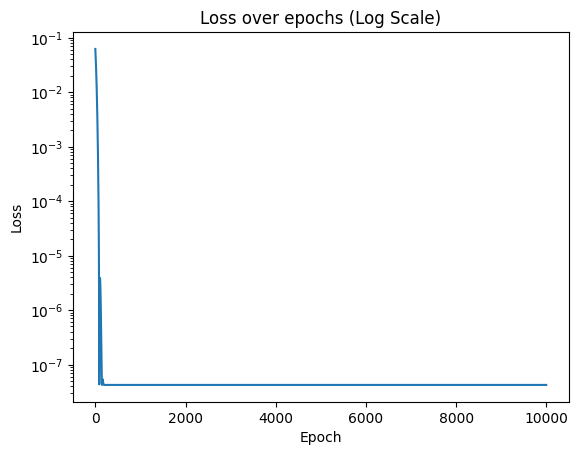

In [52]:
plt.plot(loss_array)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss over epochs (Log Scale)')
print(loss_array[-1])
plt.show()

/var/folders/h6/fydqhqf91dz2n0nt36mc0dnh0000gn/T/ipykernel_9558/2642570070.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  acc_data_tensor = torch.tensor(acc_data).float()  # Example assuming acc_data is numpy array


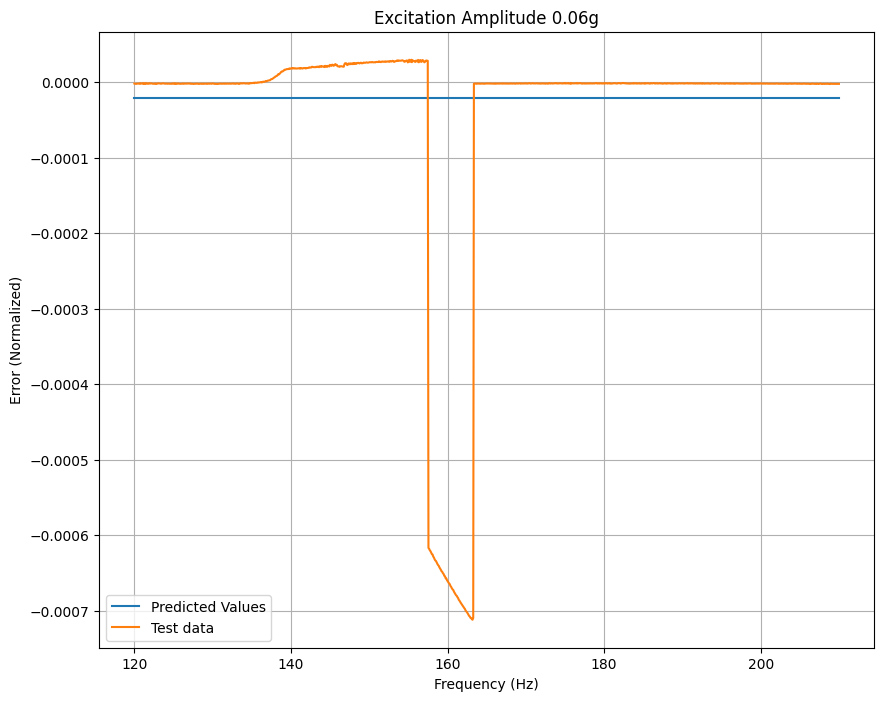

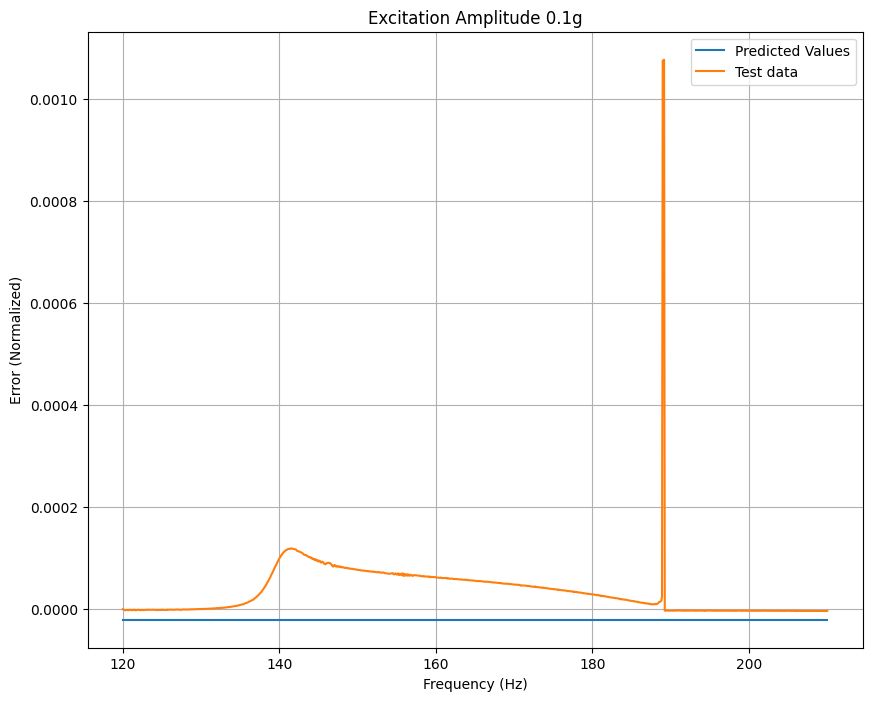

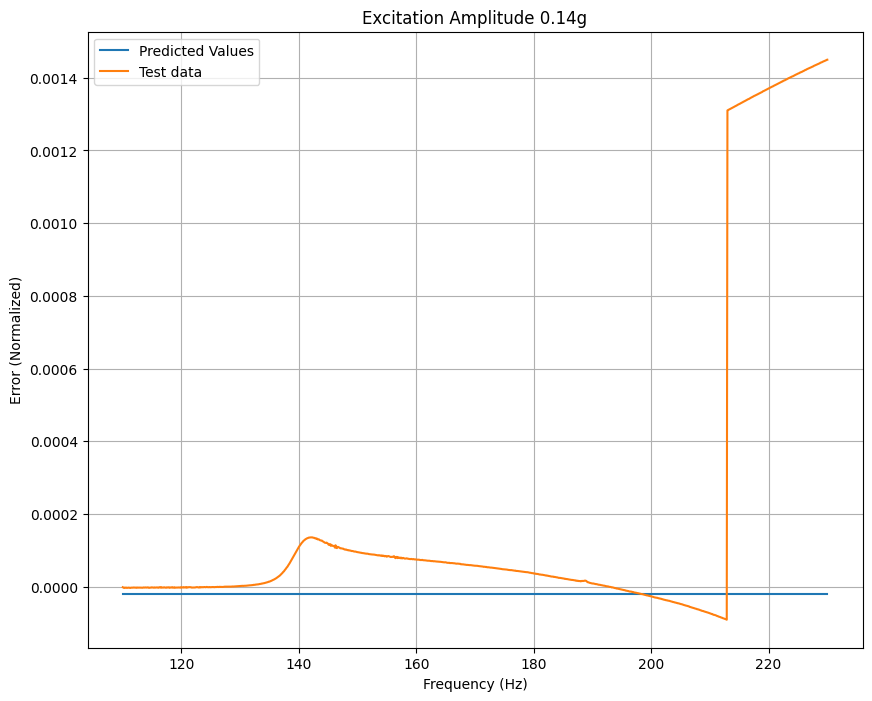

In [54]:
# Assuming 'model' is your trained neural network model (NeuralNet)

# Set the model to evaluation mode
model.eval()

# Iterate over each amplitude of excitation
for acc in amplitudes:
    mask = (X_test[:, 1] == acc)
    acc_data = X_test[mask]

    # Convert acc_data to torch tensor if necessary
    acc_data_tensor = torch.tensor(acc_data).float()  # Example assuming acc_data is numpy array
    
    # Ensure acc_data_tensor is in the correct shape, e.g., (batch_size, input_dim)

    # Use torch.no_grad() to disable gradient calculation
    with torch.no_grad():
        # Perform prediction using your model
        acc_data_prediction = model(acc_data_tensor)
    
    # Convert acc_data_prediction back to numpy array if needed
    acc_data_prediction = acc_data_prediction.numpy()  # Example assuming output is numpy array

    # Now you have acc_data_prediction as your predicted values
    
    acc_y_test = y_test[mask]

    # Plotting code remains the same
    plt.figure(figsize=(10, 8))
    plt.plot(acc_data[:, 0], acc_data_prediction, label="Predicted Values")
    plt.plot(acc_data[:, 0], acc_y_test, label="Test data")
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Error (Normalized)')
    plt.title(f'Excitation Amplitude {acc}g')
    plt.grid(True)
    plt.legend()
    plt.show()
